# Семинар 3: Методы оптимизации и скедюлеры (обещанные) и сегментация!



In [1]:
#!pip3 install torchmetrics torchvision

In [2]:
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

In [3]:

def seed_everything(seed):
    # фискирует максимум сидов для корректности сравнения разных экспериментов
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(0xBADBEEF)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Оптимизируем функцию одной переменной в **PyTorch**
Как вам показали на лекции, большинство методов машинного обучения сводятся к простому поиску параметров, который бы минимизировал ошибку на тренировочной выборке:
$$
\min_{\theta}L(p_{\theta}(X), Y)
$$
Здесь:
* $L$ - некоторый лосс,
* $p_{\theta}$ - нейронная сеть с параметрами $\theta$
* $X$ - данные для обучения,
* $Y$ - ответы

Давайте руками напишем алгоритм для поиска минимума функции $f(x) = x^{3} - 2x^{2} + 2$.

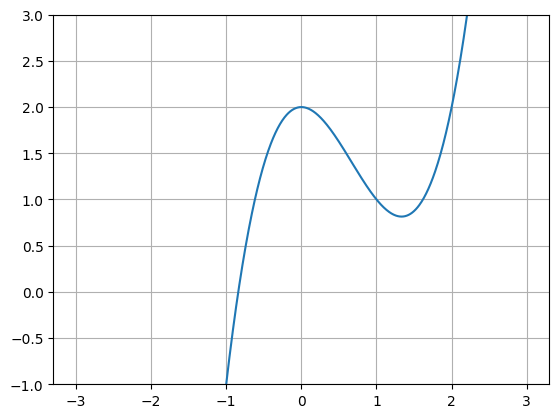

In [4]:
# наша функция f(x)
func = lambda x: x**3 - 2 * x**2 + 2
# производная функции f(x)
d_func = lambda x: 3 * x**2 - 4 * x
# сделаем массив из 1000 элементов от -3 до 3
x = np.linspace(-3, 3, 1000)
# определим границы по y для графика
plt.ylim([-1, 3])
plt.plot(x, func(x))
plt.grid()
plt.show()

Определим функцию для оптимизации $f(x)$, которая должна принимать на вход learning rate и максимальное количество итераций.

In [5]:
def find_minimum_first_order(
    learning_rate=0.01, eps=1e-4, max_iterations=1000, anneal_learning_rate=None
):
    i = 0
    x_old, x_new = 0, 2
    # будем сохранять историю значений x и y
    x_list, y_list = [x_old], [func(x_old)]
    if not anneal_learning_rate:
        anneal_learning_rate = lambda lr, step: lr

    while abs(x_new - x_old) > eps and i < max_iterations:
        # получим learning rate для текущей итерации
        learning_rate = anneal_learning_rate(learning_rate, step=i)
        # обновим x_old
        x_old = x_new
        # сделаем один шаг gradient descent
        x_new = x_old - learning_rate * d_func(x_old)
        # добавим новые значения для визуализации сходимости
        x_list.append(x_new)
        y_list.append(func(x_new))
        i += 1

    print("Найденный локальный минимум:", x_new)
    print("Количество шагов:", len(x_list))
    # Визуализируем сходимость
    plt.figure(figsize=[6, 4])
    plt.ylim([-3, 8])
    plt.scatter(x_list, y_list, c="r", edgecolors="k")
    plt.plot(x_list, y_list, c="r")
    plt.plot(x, func(x), c="b")
    plt.title("Descent trajectory")
    plt.grid()
    plt.show()

Попробуем различные `learning_rate` и посмотрим на поведение оптимизации.

Найденный локальный минимум: 1.3577577123861129
Количество шагов: 729


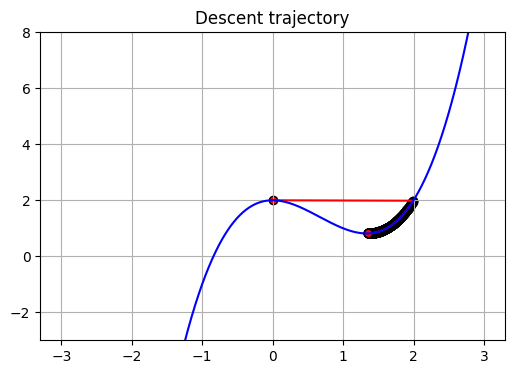

In [6]:
find_minimum_first_order(0.001)

Слишком мало, будем очень долго идти к локальному минимуму.

Найденный локальный минимум: 1.3356881625009205
Количество шагов: 129


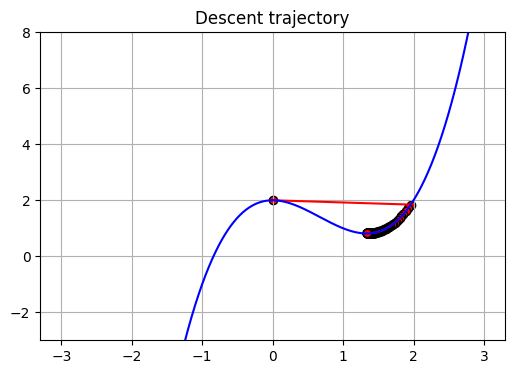

In [7]:
find_minimum_first_order(0.01)

Уже лучше.

Найденный локальный минимум: 1.3333495713163788
Количество шагов: 8


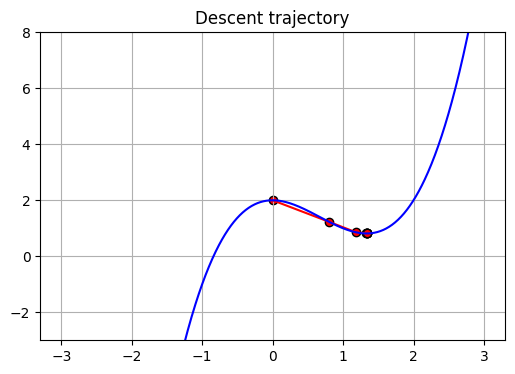

In [8]:
find_minimum_first_order(0.3)

In [9]:
find_minimum_first_order(0.6)

OverflowError: (34, 'Numerical result out of range')

Ууупс, получили Overflow. Значит learning rate слишком большой. Хотя большой learning rate опасен возможностью overflow у него есть ряд преимуществ. Чем больше темп обучения, тем большие расстояния мы преодолеваем за один шаг и тем выше вероятность быстрее найти хорошее пространство локальных минимумов.

Хорошая стратегия — начинать с достаточно большого шага (чтобы хорошо попутешествовать по функции), а потом постепенно его уменьшать, чтобы стабилизировать процесс обучения в каком-то локальном минимуме.

In [ ]:
find_minimum_first_order(0.6, anneal_learning_rate=lambda lr, step: 0.3 * lr)

## Изучаем разные методы оптимизации

### Stochastic Gradient Descent
SGD - этот же самый gradient descent, что мы рассматривали ранее, но подсчёт градиентов производится не по всему множеству данных, а по отдельно взятому сэмплу. Очевидно, такая оптимизация будет очень шумной, что усложнит обучение модели. Поэтому обычно используют MiniBatch-SGD, где вместо одного сэмпла мы берём $k$. У такого подхода ниже variance в сравнении с обычным SGD, что приводит к более стабильному процессу оптимизации. В то же время нам всё ещё не нужно работать со всей выборкой одновременно, поэтому мы можем контролировать используемую память.

$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
w &=& w - \eta \times g
\end{eqnarray}
$$

### Stochastic Gradient Descent with Momentum
Попытаемся добавить SGD эффект инерции. Теперь, вместо того чтобы двигаться строго в направлении градиента в каждой точке, мы стараемся продолжить движение в том же направлении, в котором двигались ранее. То есть у нашей точки, которая спускается по многомерной поверхности, появляется импульс (momentum), который контролируется при помощи параметра $\alpha$ (обычно $\alpha$ устанавливают величину 0.9). Он определяет какую часть прошлого градиента мы хотим использовать на текущем шаге.
$$
\begin{eqnarray}
g_{t} &=& \alpha g_{t-1} + \eta \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
w &=& w - \eta \times g
\end{eqnarray}
$$

![Momentum](https://github.com/hse-ds/iad-deep-learning/blob/master/2022/seminars/sem04/static/sgd_momentum.png?raw=1)

### Адаптивные варианты градиентного спуска

Во всех предыдущих алгоритмах у нас был фиксированный learning rate. Начиная с Adagrad у нас будут идти алгоритмы, которые подстраивают learning rate в зависимости от обучения. Они называются адаптивными вариантами градиентного спуска.

Адаптивные варианты градиентного спуска подстраивают темп обучения таким образом, чтобы делать большие или маленькие обновления отдельных параметров. Например, может так сложиться, что некоторые веса близки к своим локальным минимумам, тогда по этим координатам нужно двигаться медленнее, а другие веса ещё только в середине, значит их можно менять гораздо быстрее. Подобные методы часто приводят к более обоснованной модели и сходятся гораздо быстрее.

#### Adagrad

**Идея:** Адаптирует learning rate для каждого параметра индивидуально — делает меньшие обновления для параметров, связанных с часто встречающимися признаками, и большие обновления для параметров, связанных с редкими признаками.

**Зачем это нужно:**
- Отлично подходит для разреженных данных (sparse data)
- Google использовал Adagrad для обучения крупномасштабных нейросетей (в том числе для распознавания котов в YouTube видео)
- Используется для обучения word embeddings (GloVe), так как редкие слова требуют больших обновлений, чем частые

**Формулы:**

Для отдельного параметра $\theta_i$:

$$\theta_{t+1,i} = \theta_{t,i} - \frac{\eta}{\sqrt{G_{t,ii} + \epsilon}} \cdot g_{t,i}$$

где $G_t \in \mathbb{R}^{d \times d}$ — диагональная матрица, каждый диагональный элемент $G_{t,ii}$ которой равен сумме квадратов градиентов по параметру $\theta_i$ до момента времени $t$.

**Векторизованная форма:**

$$
\begin{eqnarray}
g_t &=& \nabla_\theta J(\theta_t) \\
G_t &=& G_{t-1} + g_t \odot g_t \\
\theta_{t+1} &=& \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \odot g_t
\end{eqnarray}
$$

где:
- $g_t$ — градиент на шаге $t$
- $G_t$ — диагональная матрица с накопленными суммами квадратов градиентов
- $\epsilon$ — малая константа для численной стабильности (обычно $10^{-8}$)
- $\odot$ — поэлементное умножение

**Примечание:** $G_t$ содержит сумму квадратов прошлых градиентов по всем параметрам $\theta$ на диагонали, что позволяет векторизовать реализацию через матрично-векторное произведение.

**Важно:** Без операции квадратного корня алгоритм работает гораздо хуже!

**Преимущества:**
- Автоматически адаптирует learning rate для каждого параметра
- Не нужно вручную подбирать learning rate — дефолтное значение 0.01 обычно работает хорошо
- Устраняет необходимость в тщательной настройке гиперпараметров

**Главный недостаток:**
Накопление квадратов градиентов в знаменателе: поскольку каждый добавляемый член положительный, накопленная сумма $G_t$ постоянно растёт во время обучения. Это приводит к тому, что learning rate уменьшается и в конечном итоге становится бесконечно малым, после чего алгоритм больше не может обучаться.

**Следующие алгоритмы (RMSprop, Adam) решают эту проблему!**

#### RMSprop

**Проблема Adagrad:** $G_t$ всегда положительна и постоянно растёт во время обучения, что приводит к ситуации, когда learning rate становится слишком маленьким, и модель перестаёт обучаться.

**Решение RMSprop:** Вместо накопления всех прошлых градиентов используется экспоненциальное скользящее среднее квадратов градиентов. Это позволяет "забывать" старые градиенты и фокусироваться на недавней истории.

**Формулы:**
$$
\begin{eqnarray}
g_t &=& \nabla_\theta J(\theta_t) \\
G_t &=& \gamma \cdot G_{t-1} + (1 - \gamma) \cdot g_t \odot g_t \\
\theta_{t+1} &=& \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \odot g_t
\end{eqnarray}
$$

где:
- $g_t$ — градиент на шаге $t$
- $G_t$ — экспоненциальное скользящее среднее квадратов градиентов (в отличие от Adagrad, не накапливается монотонно)
- $\gamma$ — коэффициент затухания (decay rate), обычно 0.9
- $\epsilon$ — малая константа для численной стабильности (обычно $10^{-8}$)
- $\odot$ — поэлементное умножение

**Ключевое отличие от Adagrad:**

Adagrad: $G_t = G_{t-1} + g_t \odot g_t$ (монотонно растёт ↗️)

RMSprop: $G_t = \gamma \cdot G_{t-1} + (1-\gamma) \cdot g_t \odot g_t$ (стабилизируется ➡️)

**Преимущества:**
- Learning rate не уменьшается монотонно — модель продолжает обучаться
- Адаптируется к недавним изменениям в градиентах
- Хорошо работает на non-stationary задачах (где оптимальная траектория меняется)

**Гиперпараметры:**
- Дефолтный learning rate $\eta = 0.001$
- Дефолтный decay rate $\gamma = 0.9$

#### Adam (Adaptive Moment Estimation)

**Идея:** Комбинирует лучшее из двух миров — Momentum (первый момент) и RMSprop (второй момент). Adam хранит экспоненциальное скользящее среднее как градиентов, так и квадратов градиентов.

**Формулы:**
$$
\begin{eqnarray}
g_t &=& \nabla_\theta J(\theta_t) \\
m_t &=& \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g_t \\
v_t &=& \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot g_t \odot g_t \\
\hat{m}_t &=& \frac{m_t}{1 - \beta_1^{t}} \\
\hat{v}_t &=& \frac{v_t}{1 - \beta_2^{t}} \\
\theta_{t+1} &=& \theta_t - \frac{\eta}{\sqrt{\hat{v}_t + \epsilon}} \odot \hat{m}_t
\end{eqnarray}
$$

где:
- $g_t$ — градиент на шаге $t$
- $m_t$ — первый момент (экспоненциальное скользящее среднее градиентов) ~ Momentum
- $v_t$ — второй момент (экспоненциальное скользящее среднее квадратов градиентов) ~ RMSprop
- $\hat{m}_t$, $\hat{v}_t$ — bias-corrected оценки моментов
- $\beta_1$ — коэффициент для первого момента (обычно 0.9)
- $\beta_2$ — коэффициент для второго момента (обычно 0.999)
- $\epsilon$ — малая константа для численной стабильности (обычно $10^{-8}$)
- $\odot$ — поэлементное умножение

**Инициализация:** $m_0 = 0$, $v_0 = 0$

**Bias correction — зачем?**

В начале обучения $m_0 = 0$ и $v_0 = 0$, поэтому оценки $m_t$ и $v_t$ смещены к нулю, особенно когда $\beta_1$ и $\beta_2$ близки к 1. Bias correction исправляет это смещение:

- Без correction: $m_1 = (1-\beta_1) \cdot g_1 = 0.1 \cdot g_1$ (слишком мало!)
- С correction: $\hat{m}_1 = \frac{0.1 \cdot g_1}{1 - 0.9^1} = \frac{0.1 \cdot g_1}{0.1} = g_1$ ✓

По мере роста $t$: $\beta_1^t \to 0$ и $\beta_2^t \to 0$, поэтому correction перестаёт влиять.

**Преимущества:**
- Работает "из коробки" с дефолтными гиперпараметрами
- Объединяет momentum (ускорение) и adaptive learning rate
- Устойчив к выбору learning rate
- Быстрая сходимость на большинстве задач

**Дефолтные гиперпараметры:**
- $\eta = 0.001$
- $\beta_1 = 0.9$
- $\beta_2 = 0.999$
- $\epsilon = 10^{-8}$

**На практике:** Используйте **AdamW** вместо Adam — это улучшенная версия с правильным weight decay, которая лучше генерализует.

#### Схема
![Sheme](https://github.com/hse-ds/iad-deep-learning/blob/master/2022/seminars/sem04/static/gd_scheme.png?raw=1)

### Работаем с PyTorch Scheduler

В начале семинара мы уменьшили количество шагов до сходимости следующим образом: начали с достаточно большого шага, а потом постепенно его уменьшили, чтобы стабилизировать процесс обучения в минимуме. Оказывается есть много способов менять оптимизацию таким образом. Они называются Schedulers.

In [ ]:

 [elem for elem in dir(torch.optim.lr_scheduler) if not elem.startswith("_")]

Основные методы PyTorch Scheduler:
* __step__ - обновление размера шага. Есть вариант обновления `learning_rate` на каждом шаге, каждый `n`-й шаг, каждую эпоху и т.д.
* __state_dict__ - получить текущее состояние Scheduler: текущий LR, количество пройденных шагов и дополнительные параметры.


### Как создать инстанс PyTorch Scheduler?

Достаточно передать `optimizer` и гиперпараметры для метода.

Рекомендуемые библиотеки:
1. `torch.optim`
2. `transformers` — https://huggingface.co/docs/transformers/en/main_classes/optimizer_schedules

Пример:

In [ ]:
model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler_func = lambda epoch: 0.65**epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, scheduler_func)

Сделаем пару небольших функций для отрисовки изменения шага обучения на разных шедулерах:


In [ ]:
def get_simple_model_optimizer():
    simple_model = torch.nn.Linear(2, 1)
    simple_optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    return simple_model, simple_optimizer


def draw_learning_rate_curve(optimizer, scheduler):
    lrs = []
    for i in range(100):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
    plt.grid()
    plt.plot(range(100), lrs)

### Примеры различных шедулеров в **PyTorch**

#### Lambda LR
Умножает шаг на значение данной ему функции: $lr_{epoch} = lr_{initial} * Lambda(epoch)$.

In [ ]:
model, optimizer = get_simple_model_optimizer()
lambda_func = lambda epoch: 0.95**epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)
draw_learning_rate_curve(optimizer, scheduler)

#### StepLR
Каждые `step_size` эпох уменьшает LR в `gamma` раз.

In [ ]:
model, optimizer = get_simple_model_optimizer()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
draw_learning_rate_curve(optimizer, scheduler)

#### CosineAnnealingLR

Важно понимать, что LR имеет смысл не только снижать, но иногда еще и делать цикличным. Формула тут несколько сложнее, оставим ее для интересующихся)

In [ ]:
model, optimizer = get_simple_model_optimizer()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
draw_learning_rate_curve(optimizer, scheduler)

### Schedulers с Warmup из **Transformers**

Warmup — это постепенное увеличение learning rate в начале обучения. Это помогает:
- Избежать больших градиентов на начальных шагах
- Стабилизировать обучение больших моделей
- Улучшить сходимость

In [ ]:
# !pip install transformers

#### Linear Schedule with Warmup

Линейное увеличение LR во время warmup, затем линейное уменьшение до нуля.


In [ ]:
from transformers import get_linear_schedule_with_warmup

model, optimizer = get_simple_model_optimizer()

num_training_steps = 100
num_warmup_steps = 10  # 10% warmup

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

draw_learning_rate_curve(optimizer, scheduler)

#### Cosine Schedule with Warmup

Линейное увеличение во время warmup, затем косинусоидальное уменьшение.

In [ ]:
from transformers import get_cosine_schedule_with_warmup

model, optimizer = get_simple_model_optimizer()

num_training_steps = 100
num_warmup_steps = 10

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
    num_cycles=0.5  # количество полных косинусоид (обычно 0.5)
)

draw_learning_rate_curve(optimizer, scheduler)

## Image Segmentation


Что такое Segmentation?

Segmentation — это задача классификации каждого пикселя изображения. В отличие от *classification* (один label на всё изображение) или *detection* (bounding box вокруг объекта), segmentation присваивает класс каждому пикселю.

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


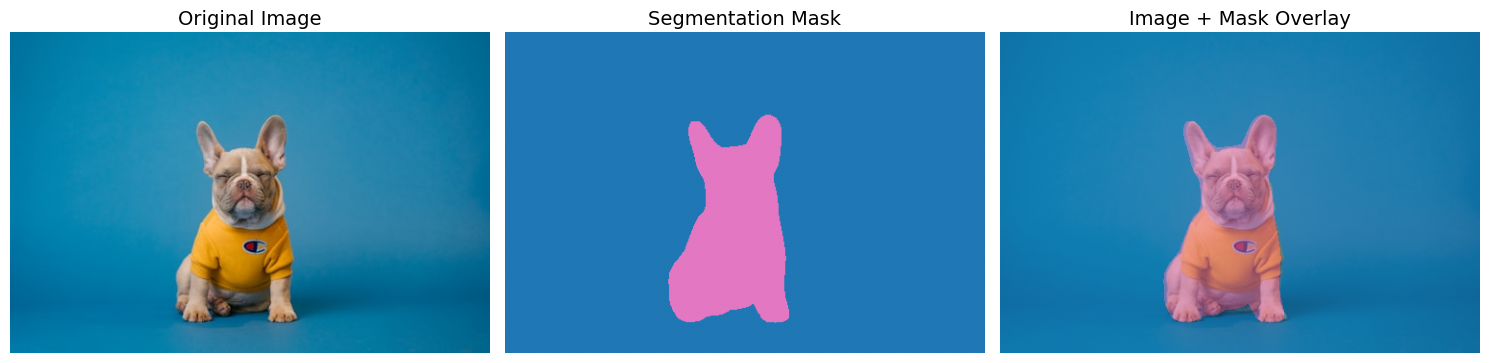

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50

# Загрузим изображение
url = "https://images.unsplash.com/photo-1583511655857-d19b40a7a54e?w=500"
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert('RGB')

# Загрузим pretrained модель
model = deeplabv3_resnet50(pretrained=True)
model.eval()

# Preprocessing
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(image).unsqueeze(0)

# Inference
with torch.no_grad():
    output = model(input_tensor)['out'][0]

output_predictions = output.argmax(0).byte().cpu().numpy()

# Визуализация
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Original
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=14)
ax1.axis('off')

# Segmentation mask
colors = plt.cm.tab20(np.linspace(0, 1, 21))
segmentation_mask = colors[output_predictions][:, :, :3]

ax2.imshow(segmentation_mask)
ax2.set_title('Segmentation Mask', fontsize=14)
ax2.axis('off')

# Overlay
ax3.imshow(image)
ax3.imshow(segmentation_mask, alpha=0.5)
ax3.set_title('Image + Mask Overlay', fontsize=14)
ax3.axis('off')

plt.tight_layout()
plt.show()

## Типы сегментации

### Semantic Segmentation
Каждый пиксель получает метку класса. Не различает *отдельные* экземпляры одного класса.


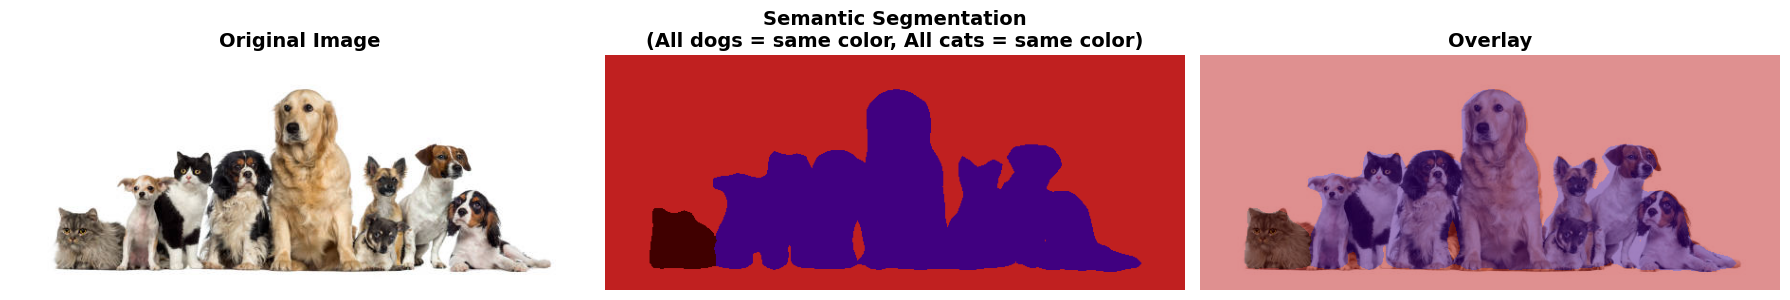

Detected classes:
  background: 66.3%
  cat: 2.4%
  dog: 31.2%


In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50

# Загрузим картинку с группой кошек и собак
url = "https://media.istockphoto.com/id/1068752290/photo/group-of-dogs-and-a-cat.jpg?s=612x612&w=0&k=20&c=nypft67V7uVU2M8P6tieX_Qbf_m7umcxjbtah47FdQc="
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert('RGB')

# Pretrained модель для semantic segmentation (DeepLabV3)
model = deeplabv3_resnet50(pretrained=True)
model.eval()

# Preprocessing
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(image).unsqueeze(0)

# Inference
with torch.no_grad():
    output = model(input_tensor)['out'][0]

# Получаем класс для каждого пикселя
segmentation = output.argmax(0).byte().cpu().numpy()

# PASCAL VOC classes (21 класс)
classes = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

# Создаём цветную маску
palette = np.array([
    [192, 32, 32], [128, 0, 0], [0, 128, 0], [128, 128, 0],
    [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
    [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
    [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
    [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
])

color_seg = np.zeros((segmentation.shape[0], segmentation.shape[1], 3), dtype=np.uint8)
for label, color in enumerate(palette):
    color_seg[segmentation == label, :] = color

# Визуализация
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=14, fontweight='bold')
ax1.axis('off')

ax2.imshow(color_seg)
ax2.set_title('Semantic Segmentation\n(All dogs = same color, All cats = same color)',
              fontsize=14, fontweight='bold')
ax2.axis('off')

ax3.imshow(image)
ax3.imshow(color_seg, alpha=0.5)
ax3.set_title('Overlay', fontsize=14, fontweight='bold')
ax3.axis('off')

plt.tight_layout()
plt.show()

# Какие классы найдены
unique_labels = np.unique(segmentation)
print("Detected classes:")
for label in unique_labels:
    if label < len(classes):
        pixel_count = np.sum(segmentation == label)
        percentage = (pixel_count / segmentation.size) * 100
        print(f"  {classes[label]}: {percentage:.1f}%")

Особенность: Если на изображении 2 кота, они будут окрашены одним цветом — модель не различает их как отдельные объекты.

### Instance Segmentation
Различает отдельные экземпляры объектов одного класса.

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


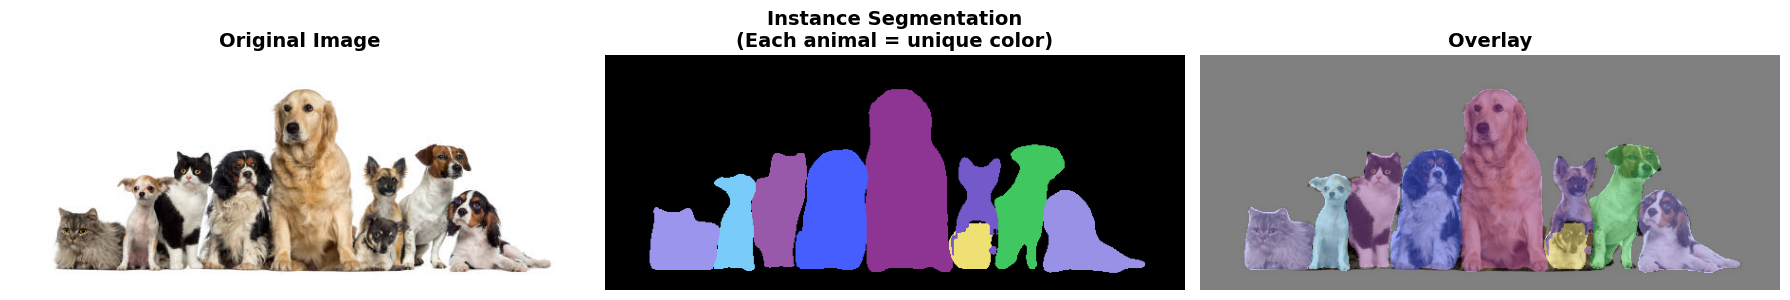

Detected instances:
  dog: 1.00
  dog: 1.00
  dog: 1.00
  cat: 1.00
  dog: 1.00
  dog: 0.99
  dog: 0.99
  cat: 0.99
  dog: 0.99

Total instances: 9


In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn

# Загрузим изображение
url = "https://media.istockphoto.com/id/1068752290/photo/group-of-dogs-and-a-cat.jpg?s=612x612&w=0&k=20&c=nypft67V7uVU2M8P6tieX_Qbf_m7umcxjbtah47FdQc="
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert('RGB')

# Pretrained модель для instance segmentation (Mask R-CNN)
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Preprocessing
transform = transforms.Compose([transforms.ToTensor()])
input_tensor = transform(image).unsqueeze(0)

# Inference
with torch.no_grad():
    predictions = model(input_tensor)[0]

# COCO classes
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
    'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A',
    'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Фильтруем по threshold
threshold = 0.7
keep = predictions['scores'] > threshold
masks = predictions['masks'][keep]
labels = predictions['labels'][keep]
scores = predictions['scores'][keep]

# Создаём instance mask (каждый экземпляр свой цвет)
h, w = image.size[1], image.size[0]
instance_mask = np.zeros((h, w, 3), dtype=np.uint8)

np.random.seed(42)
for i, mask in enumerate(masks):
    # Случайный цвет для каждого экземпляра
    color = np.random.randint(50, 255, size=3, dtype=np.uint8)

    mask = mask[0].numpy() > 0.5
    instance_mask[mask] = color

# Визуализация
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=14, fontweight='bold')
ax1.axis('off')

ax2.imshow(instance_mask)
ax2.set_title('Instance Segmentation\n(Each animal = unique color)', fontsize=14, fontweight='bold')
ax2.axis('off')

ax3.imshow(image)
ax3.imshow(instance_mask, alpha=0.5)
ax3.set_title('Overlay', fontsize=14, fontweight='bold')
ax3.axis('off')

plt.tight_layout()
plt.show()

# Detected instances
print("Detected instances:")
for label, score in zip(labels, scores):
    class_name = COCO_CLASSES[label.item()]
    print(f"  {class_name}: {score:.2f}")

print(f"\nTotal instances: {len(labels)}")

### Panoptic Segmentation

Различает отдельные экземпляры объектов одного класса.

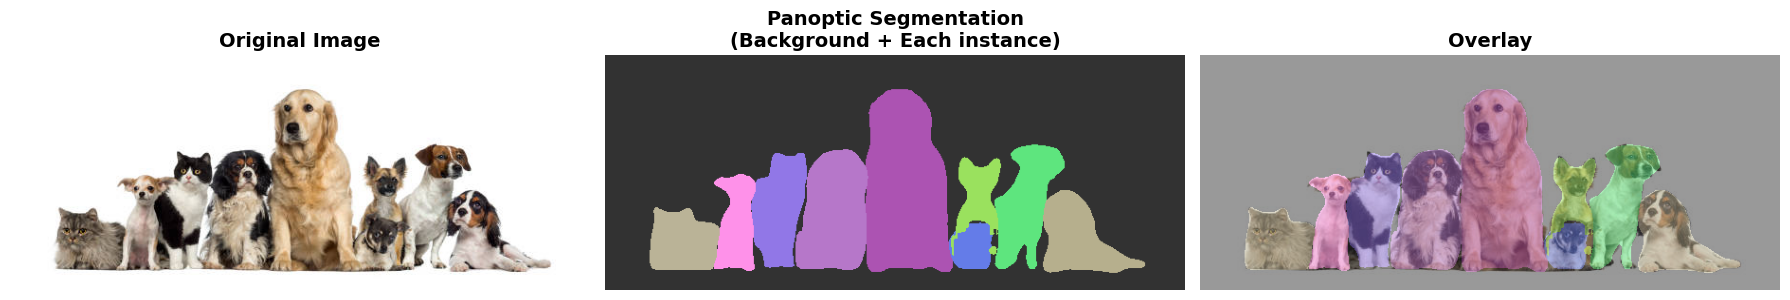

Panoptic Segmentation Results:
Background (stuff): gray

Detected instances (things):
  dog: 1.00
  dog: 1.00
  dog: 1.00
  cat: 1.00
  dog: 1.00
  dog: 0.99
  dog: 0.99
  cat: 0.99
  dog: 0.99

Total: 9 instances + background


In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn

# Загрузим изображение
url = "https://media.istockphoto.com/id/1068752290/photo/group-of-dogs-and-a-cat.jpg?s=612x612&w=0&k=20&c=nypft67V7uVU2M8P6tieX_Qbf_m7umcxjbtah47FdQc="
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert('RGB')

# Pretrained модель
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Preprocessing
transform = transforms.Compose([transforms.ToTensor()])
input_tensor = transform(image).unsqueeze(0)

# Inference
with torch.no_grad():
    predictions = model(input_tensor)[0]

# COCO classes
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
    'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A',
    'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Фильтруем по threshold
threshold = 0.7
keep = predictions['scores'] > threshold
masks = predictions['masks'][keep]
labels = predictions['labels'][keep]
scores = predictions['scores'][keep]

# Panoptic = фон (semantic) + объекты (instance)
h, w = image.size[1], image.size[0]
panoptic_mask = np.zeros((h, w, 3), dtype=np.uint8)

# Фон (stuff) - серый
panoptic_mask[:, :] = [50, 50, 50]

# Объекты (things) - каждый свой цвет
np.random.seed(42)
for i, (mask, label) in enumerate(zip(masks, labels)):
    color = np.random.randint(80, 255, size=3, dtype=np.uint8)

    mask = mask[0].numpy() > 0.5
    panoptic_mask[mask] = color

# Визуализация
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=14, fontweight='bold')
ax1.axis('off')

ax2.imshow(panoptic_mask)
ax2.set_title('Panoptic Segmentation\n(Background + Each instance)', fontsize=14, fontweight='bold')
ax2.axis('off')

ax3.imshow(image)
ax3.imshow(panoptic_mask, alpha=0.5)
ax3.set_title('Overlay', fontsize=14, fontweight='bold')
ax3.axis('off')

plt.tight_layout()
plt.show()

# Detected instances
print("Panoptic Segmentation Results:")
print(f"Background (stuff): gray")
print(f"\nDetected instances (things):")
for label, score in zip(labels, scores):
    class_name = COCO_CLASSES[label.item()]
    print(f"  {class_name}: {score:.2f}")

print(f"\nTotal: {len(labels)} instances + background")

## Что мы видели:

* Semantic segmentation (DeepLabV3)
* Instance segmentation (Mask R-CNN)  
* Panoptic segmentation (Mask R-CNN)

**Но это всё — pretrained модели!**

И они сложные... Рассказывать про них можно долго. Пока что давайте их оставим. Так что возникает вопрос:

## Как обучить свою модель для segmentation?

Для этого используем **U-Net** — самую популярную архитектуру:
- Encoder-Decoder структура
- Skip connections
- Можно обучить с нуля на своих данных
- Простая и эффективная

**Сейчас разберём U-Net детально и обучим на практике!**

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png">


Окей, сжимать исходную картинку в feature map с большим количеством каналов мы умеем. А как из "боттлнека" получить обратно картинку?

Для этого знакомимся с операцией **nn.ConvTranspose2d**.

**Зачем она?**
Если операция свертки "сворачивает" (convolution) изображение, то, грубо говоря, эта операция обратная — "разворачивает" (deconvolution). Однако важно понимать, что тут нет вычисления значения, обратного свертке, поэтому не совсем верно называть это deconvolution. В модели U-net мы сворачиваем картинку, а затем будем разворачивать, поэтому без данного способа нам не обойтись.


**Как работает?**
Принимает на вход такие же параметры как Conv2d. Подробнее можно почитать в [объяснении со stackoverflow](https://stackoverflow.com/questions/69782823/understanding-the-pytorch-implementation-of-conv2dtranspose).

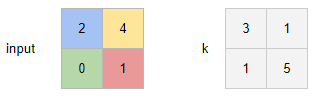

Примеры ниже показывают частные случаи и выходы после данной операции.

**stride=1, padding=0: output is 3x3**
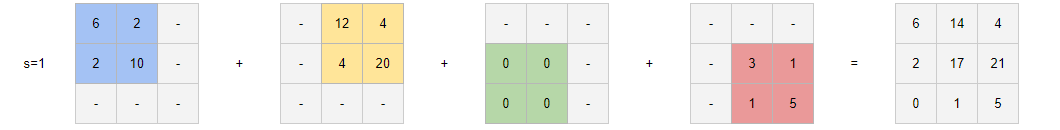

**stride=1, padding=1: output is 1x1**
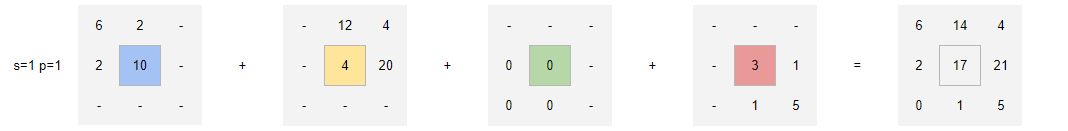

**stride=2, padding=0: output is 4x4**
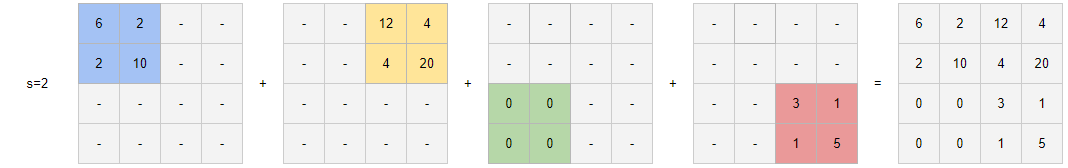

**stride=2, padding=1: output is 2x2**
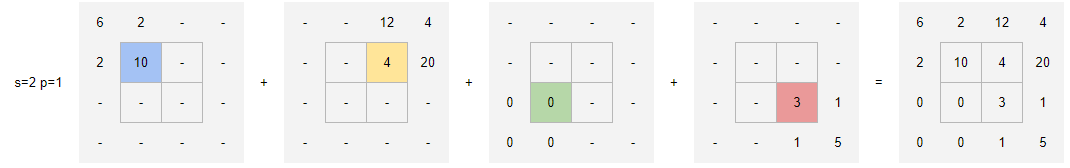

### Skip Connection

Skip connections в архитектуре U-Net — это по сути мосты между разными частями сети.

Если представить процесс обработки изображения:

* Сначала сеть сжимает изображение, чтобы понять общий контекст и крупные объекты

* Потом восстанавливает детализацию для точного определения границ

**Проблема**: При сжатии теряются мелкие детали и точные границы объектов

**Решение**: Skip connections — это прямые соединения, которые передают информацию из начальных слоёв (где много деталей) в конечные слои (где есть понимание контекста).

Что это даёт на практике:

1. Сохраняются мелкие детали и четкие границы

2. Ускоряется обучение сети

3. Улучшается точность сегментации — особенно для сложных форм

4. Сеть лучше справляется с объектами разного размера

Проще говоря: это как если бы вы, собирая пазл, одновременно смотрели и на общую картинку на коробке (контекст), и на отдельные детали кусочков — так получается и точнее, и быстрее.

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

# Скачиваем датасет
!wget https://www.dropbox.com/s/tc1qo73rrm3gt3m/CARVANA.zip
!unzip -q CARVANA.zip -d CARVANA
!rm -rf CARVANA.zip

# Проверим структуру
print("Dataset structure:")
print(f"Images: {len(os.listdir('CARVANA/train'))} files")
print(f"Masks: {len(os.listdir('CARVANA/train_masks'))} files")

--2025-11-28 10:41:05--  https://www.dropbox.com/s/tc1qo73rrm3gt3m/CARVANA.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/30c6e8n7m10hbpd2uhv76/CARVANA.zip?rlkey=1wcqbfpj1l5lpz1uq2a7jqcfh [following]
--2025-11-28 10:41:05--  https://www.dropbox.com/scl/fi/30c6e8n7m10hbpd2uhv76/CARVANA.zip?rlkey=1wcqbfpj1l5lpz1uq2a7jqcfh
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf2c7e20ab03896cb75b461bf31.dl.dropboxusercontent.com/cd/0/inline/C2AkEQmT1qSRF-T1Lp488AKTO9k4dPbk_0MRfCnJBnRxHSjwV9NqDk7jW-gpnrhVeXxTk74f_TBpEuDllsUbmo5aZj8PpJW1J5O1A1geeUDVvVfvdwd68Aekr3hKZ7mhh4d-E8c6Xek8vQc0tHZHFpIp/file# [following]
--2025-11-28 10:41:06--  https://ucf2c7e20ab03896cb75b461bf31.dl.dropboxusercontent.com/cd/0/inline/C

#### Задание 1

Давайте настроим `train` и `val` transforms. Что будем прописывать?

In [26]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.images = sorted([f for f in os.listdir(image_dir)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Загружаем изображение
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = np.array(Image.open(img_path).convert("RGB"))

        # Загружаем маску
        mask_name = self.images[idx].replace(".jpg", "_mask.gif")
        mask_path = os.path.join(self.mask_dir, mask_name)
        mask = np.array(Image.open(mask_path).convert("L"))

        # Применяем augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Маска: 0 или 1 (бинарная сегментация)
        mask = mask.float().unsqueeze(0) / 255.0  # [1, H, W]

        return image, mask


# Train transforms (с аугментациями)
train_transform = A.Compose([
    # "YOUR CODE"

    ToTensorV2()
])

# Val transforms (без аугментаций)
val_transform = A.Compose([
    # "YOUR CODE"

    ToTensorV2()
])

# Создаём полный dataset
full_dataset = CarvanaDataset(
    image_dir='CARVANA/train',
    mask_dir='CARVANA/train_masks',
    transform=None  # transform добавим позже
)

# Train/Val split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_indices, val_indices = torch.utils.data.random_split(
    range(len(full_dataset)),
    [train_size, val_size]
)

# Создаём datasets с разными transforms
train_dataset = torch.utils.data.Subset(
    CarvanaDataset('CARVANA/train', 'CARVANA/train_masks', transform=train_transform),
    train_indices.indices
)

val_dataset = torch.utils.data.Subset(
    CarvanaDataset('CARVANA/train', 'CARVANA/train_masks', transform=val_transform),
    val_indices.indices
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")

Train size: 4057
Val size: 1015


In [31]:
# Посмотрим на примеры
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(4):
    image, mask = val_dataset[i]

    # Image
    axes[0, i].imshow(image.permute(1, 2, 0))
    axes[0, i].set_title(f'Image {i}')
    axes[0, i].axis('off')

    # Mask
    axes[1, i].imshow(mask.squeeze(), cmap='gray')
    axes[1, i].set_title(f'Mask {i}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

#### Задание 2

U-net Architecture. Восстановите пропуски

In [17]:
class DoubleConv(nn.Module):
    """Два последовательных Conv -> BatchNorm -> ReLU блока"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        # Encoder (downsampling)
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)

        # YOUR CODE: добавьте MaxPooling для downsampling
        self.pool = # YOUR CODE

        # Bottleneck
        self.bottleneck = DoubleConv(256, 512)

        # Decoder (upsampling)
        # YOUR CODE: добавьте ConvTranspose2d для upsampling
        self.up1 = # YOUR CODE (512 -> 256)
        self.dec1 = DoubleConv(512, 256)  # 512 потому что concat с encoder

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        # YOUR CODE: добавьте up3 и dec3
        self.up3 = # YOUR CODE
        self.dec3 = # YOUR CODE

        # Final output layer
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc3))

        # Decoder with skip connections
        dec1 = self.up1(bottleneck)
        # YOUR CODE: concat enc{num} (кстати, какой именно enc нам нужен?) и dec1 по channel dimension
        dec1 = ...
        dec1 = self.dec1(dec1)

        dec2 = self.up2(dec1)
        # YOUR CODE: concat enc{num} и dec1 по channel dimension
        dec2 = ...
        dec2 = self.dec2(dec2)

        # YOUR CODE: decoder 3 (аналогично dec1 и dec2)
        dec3 = # YOUR CODE

        # Output
        out = self.out(dec3)
        return out

# Создаём модель
model = UNet(in_channels=3, out_channels=1)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 7,702,977


### Losses

Перед тем, как начать обучать сегментацию, давайте обсудим, какую функцию потерь использовать для данной задачи?


#### Binary Cross-Entropy (BCE)


$$L_{BCE} = -\frac{1}{N}\sum_{i=1}^{N} [y_i \log(\sigma(p_i)) + (1-y_i)\log(1-\sigma(p_i))]$$

где
σ — sigmoid функция,
$y_{i}$​ — ground truth,
$p_{i}$​ — предсказание

Когда использовать:

* Baseline для начала
* Сбалансированные классы (50/50)

Минусы:

* Плохо работает при class imbalance

#### Dice Loss

Формула:

$$\text{Dice} = \frac{2 \cdot |X \cap Y|}{|X| + |Y|}$$

$$L_{Dice} = 1 - \text{Dice}$$


Когда использовать:

* Medical imaging (опухоли, органы)
* Маленькие объекты
* Несбалансированные классы

Плюсы:

* Устойчив к class imbalance
* Напрямую оптимизирует метрику Dice

#### Focal Loss

Формула:

$$L_{Focal} = -\alpha (1-p_t)^\gamma \log(p_t)$$


где
γ — focusing parameter (обычно 2),
α — balancing factor (обычно 0.25)

Когда использовать:

* Сильный class imbalance (99% фон, 1% объект)
* Hard examples (сложные пиксели)

#### Combined Loss (BCE + Dice)

Формула:

$$L_{Combined} = \lambda_1 \cdot L_{BCE} + \lambda_2 \cdot L_{Dice}$$

обычно λ1=λ2=0.5
Когда использовать:

* Рекомендуется по умолчанию!
* Стабильное обучение (BCE) + хороший IoU (Dice)


### Метрики

#### Dice Coefficient (F1-Score)

![Dice](https://miro.medium.com/v2/resize:fit:1200/1*tSqwQ9tvLmeO9raDqg3i-w.png)

Формула:

$$\text{Dice} = \frac{2 \cdot TP}{2 \cdot TP + FP + FN}$$


Интерпретация:

* 1.0 = идеальное совпадение
* 0.5 = среднее
* < 0.3 = плохо

Самая популярная метрика для segmentation!

**Плюсы**:

* Стандарт в Medical AI
* Более чувствительна к маленьким объектам
* Больше значения → выглядит лучше

**Минусы**:

* Может быть слишком оптимистичной;

#### IoU (Intersection over Union / Jaccard Index)

![iou](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2016/09/iou_equation.png?lossy=2&strip=1&webp=1)

Формула:
$$\text{IoU} = \frac{|X \cap Y|}{|X \cup Y|} = \frac{TP}{TP + FP + FN}$$


Интерпретация:

* IoU > 0.7 = отлично
* IoU > 0.5 = хорошо
* IoU < 0.3 = плохо

Связь с Dice:

$$\text{Dice} = \frac{2 \cdot \text{IoU}}{1 + \text{IoU}}$$


**Плюсы:**

* Более строгая метрика
* Стандарт в Computer Vision

**Минусы:**

* Меньше значения → может казаться, что модель хуже






#### Pixel Accuracy

Формула:

$$\text{Acc} = \frac{TP + TN}{TP + TN + FP + FN}$$

Внимание! Может быть misleading при imbalance:

* 95% фон → модель предсказывает всё как фон → 95% accuracy, но бесполезна!

## Особенности сегментации

В задачах сегментации:

* TP - правильно предсказанные пиксели объекта

* FP - пиксели фона, ошибочно предсказанные как объект

* FN - пиксели объекта, ошибочно предсказанные как фон

* TN - правильно предсказанные пиксели фона


### Проблема с TN

В большинстве задач сегментации **TN доминирует** над другими классами:

```python
# Пример для изображения 512x512
total_pixels = 512 * 512  # 262,144 пикселей
TP, FP, FN = 70, 20, 10
TN = total_pixels - (TP + FP + FN)  # 262,044

print(f"TN составляет: {TN/total_pixels*100:.1f}% от всех пикселей")
# Результат: TN составляет: 99.96% от всех пикселей
```

### Почему TN исключают

Если включить TN:

* Метрика становится нечувствительной к качеству сегментации объекта

* Можно получить высокий score, просто правильно предсказывая фон

* Не отражает реальное качество обнаружения объектов


Training loop

In [29]:
import wandb

# Инициализация wandb
wandb.init(
    project="unet-segmentation",
    config={
        "architecture": "U-Net",
        "dataset": "Carvana",
        "epochs": 5,
        "batch_size": 8,
        "learning_rate": 0.001,
        "optimizer": "Adam",
        "loss": "Focal",  # Выбери: "BCE", "Dice", "Focal", "Combined"
        "image_size": 128
    }
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Простая реализация Dice Loss
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred = pred.view(-1)
        target = target.view(-1)

        intersection = (pred * target).sum()
        dice = (2. * intersection + 1) / (pred.sum() + target.sum() + 1)

        return 1 - dice

# Focal Loss для борьбы с class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, target):
        # BCE loss
        bce_loss = F.binary_cross_entropy_with_logits(pred, target, reduction='none')

        # Focal term
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss

        return focal_loss.mean()

# Метрики для оценки
def dice_coefficient(pred, target, threshold=0.5):
    """Dice Coefficient = 2*TP / (2*TP + FP + FN)"""
    pred = (torch.sigmoid(pred) > threshold).float()
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection) / (pred.sum() + target.sum() + 1e-8)

    return dice.item()

def iou_score(pred, target, threshold=0.5):
    """IoU = TP / (TP + FP + FN)"""
    pred = (torch.sigmoid(pred) > threshold).float()
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = intersection / (union + 1e-8)

    return iou.item()

# Выбор Loss function
loss_type = wandb.config.loss

if loss_type == "BCE":
    criterion = nn.BCEWithLogitsLoss()
elif loss_type == "Dice":
    criterion = DiceLoss()
elif loss_type == "Focal":
    criterion = FocalLoss(alpha=0.25, gamma=2.0)
elif loss_type == "Combined":
    bce_loss = nn.BCEWithLogitsLoss()
    dice_loss = DiceLoss()
    def combined_criterion(pred, target):
        return 0.5 * bce_loss(pred, target) + 0.5 * dice_loss(pred, target)
    criterion = combined_criterion

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for images, masks in tqdm(loader, desc="Training"):
        images = images.to(device)
        masks = masks.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        wandb.log({"batch/train_loss": loss.item()})

    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_dice = 0
    total_iou = 0

    example_images = []
    example_masks = []
    example_preds = []

    with torch.no_grad():
        for i, (images, masks) in enumerate(tqdm(loader, desc="Validation")):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            # Compute metrics
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)

            total_loss += loss.item()
            total_dice += dice
            total_iou += iou

            if i == 0:
                example_images = images[:4].cpu()
                example_masks = masks[:4].cpu()
                example_preds = torch.sigmoid(outputs[:4]).cpu()

    avg_loss = total_loss / len(loader)
    avg_dice = total_dice / len(loader)
    avg_iou = total_iou / len(loader)

    return avg_loss, avg_dice, avg_iou, example_images, example_masks, example_preds

# Training
num_epochs = 5

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_dice, val_iou, example_images, example_masks, example_preds = validate(
        model, val_loader, criterion, device
    )

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Val Dice: {val_dice:.4f}")
    print(f"  Val IoU: {val_iou:.4f}")

    wandb.log({
        "epoch": epoch + 1,
        "train/loss": train_loss,
        "val/loss": val_loss,
        "val/dice": val_dice,
        "val/iou": val_iou,
    })

    # Log примеры предсказаний
    wandb_images = []
    for i in range(len(example_images)):
        img = example_images[i].permute(1, 2, 0).numpy()
        mask = example_masks[i].squeeze().numpy()
        pred = example_preds[i].squeeze().numpy()

        # Denormalize
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        wandb_images.append(wandb.Image(
            img,
            masks={
                "ground_truth": {"mask_data": mask, "class_labels": {0: "background", 1: "car"}},
                "prediction": {"mask_data": pred, "class_labels": {0: "background", 1: "car"}}
            },
            caption=f"Epoch {epoch+1}"
        ))

    wandb.log({"predictions": wandb_images})

wandb.finish()
print("Training complete!")

#### Визуализация результатов после обучения

In [30]:
model.eval()

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

with torch.no_grad():
    for i in range(4):
        image, mask = val_dataset[i]

        # Prediction
        image_input = image.unsqueeze(0).to(device)
        pred = model(image_input)
        pred = torch.sigmoid(pred).cpu().squeeze()

        # Original image
        axes[0, i].imshow(image.permute(1, 2, 0))
        axes[0, i].set_title(f'Image {i}')
        axes[0, i].axis('off')

        # Ground truth mask
        axes[1, i].imshow(mask.squeeze(), cmap='gray')
        axes[1, i].set_title('Ground Truth')
        axes[1, i].axis('off')

        # Predicted mask
        axes[2, i].imshow(pred, cmap='gray')
        axes[2, i].set_title('Prediction')
        axes[2, i].axis('off')

plt.tight_layout()
plt.show()